# Low-Rank Gromov-Wasserstein

We try in this colab the low-rank (LR) Gromov-Wasserstein Solver, proposed by <cite data-cite="scetbon:22">Scetbon et al.</cite>, a follow up to the LR Sinkhorn solver in <cite data-cite="scetbon:21">Scetbon et al.</cite>.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

In [3]:
import jax.numpy as jnp
import jax
import ott
import matplotlib.pyplot as plt

In [4]:
def create_points(rng, n, m, d1, d2):
    rngs = jax.random.split(rng, 5)
    x = jax.random.uniform(rngs[0], (n, d1))
    y = jax.random.uniform(rngs[1], (m, d2))
    a = jax.random.uniform(rngs[2], (n,))
    b = jax.random.uniform(rngs[3], (m,))
    a = a / jnp.sum(a)
    b = b / jnp.sum(b)
    z = jax.random.uniform(rngs[4], (m, d1))
    return x, y, a, b, z


rng = jax.random.PRNGKey(0)
n, m, d1, d2 = 24, 17, 2, 3
x, y, a, b, z = create_points(rng, n, m, d1, d2)

Create two toy point clouds of heterogeneous size, and add a third geometry to provide a fused problem (see <cite data-cite="vayer:20">Vayer et al.</cite>).


In [5]:
geom_xx = ott.geometry.pointcloud.PointCloud(x)
geom_yy = ott.geometry.pointcloud.PointCloud(y)
# below `z` is there only to create n x m geometry
geom_xy = ott.geometry.pointcloud.PointCloud(x, z)
prob = ott.core.quad_problems.QuadraticProblem(
    geom_xx,
    geom_yy,
    geom_xy=geom_xy,
    a=a,
    b=b,
)

Solve the problem using the Low-Rank Sinkhorn solver.

In [6]:
solver = ott.core.gromov_wasserstein.GromovWasserstein(rank=6)
ot_gwlr = solver(prob)

Run it with entropic-GW for the sake of comparison

In [7]:
solver = ott.core.gromov_wasserstein.GromovWasserstein(epsilon=0.05)
ot_gw = solver(prob)

One can notice that their outputs are quantitatively similar.

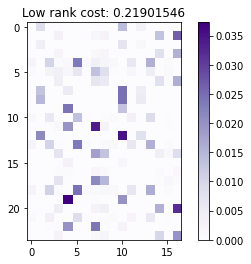

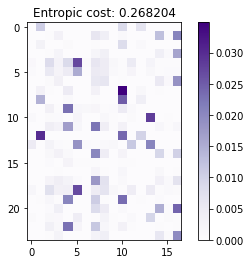

In [8]:
def plot_ot(ot, leg):
    plt.imshow(ot.matrix, cmap="Purples")
    plt.colorbar()
    plt.title(leg + " cost: " + str(ot.costs[ot.costs > 0][-1]))
    plt.show()


plot_ot(ot_gwlr, "Low rank")
plot_ot(ot_gw, "Entropic")